In [92]:
import xarray as xr

In [93]:
ds = xr.open_mfdataset("00010101.ocean_hourly_sclr_thck_*.nc")
ds_natv = xr.merge([
    xr.open_mfdataset("00010101.ocean_hourly_natv_thck_*.nc"),
    xr.open_mfdataset("00010101.ocean_hourly_natv_heat_*.nc")
])
og = xr.open_dataset("00010101.ocean_static.nc")

/Users/henrifdrake/anaconda3/envs/xwmb_stack/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/henrifdrake/anaconda3/envs/xwmb_stack/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/henrifdrake/anaconda3/envs/xwmb_stack/lib/python3.12/site-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calenda

In [94]:
import numpy as np
zi = np.concatenate([[0], 0.5*(ds_natv.zl.values[1:] + ds_natv.zl.values[:-1]), [6000]])
ds_natv = ds_natv.assign_coords({"zi": xr.DataArray(zi, dims=("zi",))})

In [95]:
from xgcm import Grid
# z-coordinate dataset containing basic state variables
coords = {
    'X': {'center': 'xh'},
    'Y': {'center': 'yh'},
    'Z': {'center': 'zl', 'outer': 'zi'},
}
boundary = {"X":"extend", "Y":"extend", "Z":"extend"}
grid = Grid(ds_natv, coords=coords, boundary=boundary, autoparse_metadata=False)

/Users/henrifdrake/anaconda3/envs/xwmb_stack/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/Users/henrifdrake/anaconda3/envs/xwmb_stack/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/Users/henrifdrake/anaconda3/envs/xwmb_stack/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out 

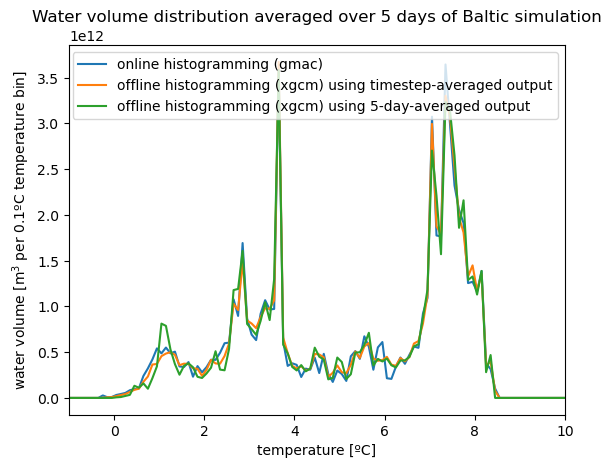

In [96]:
ds_off_lo = grid.transform(ds_natv.thkcello.fillna(0.).mean("time"), "Z", ds.scalar_i.values, target_data=ds_natv.temp.mean("time"), method="conservative")
ds_off_hi = grid.transform(ds_natv.thkcello.fillna(0.), "Z", ds.scalar_i.values, target_data=ds_natv.temp, method="conservative").mean("time")

import matplotlib.pyplot as plt
(ds.thkcello.mean("time")*og.areacello).sum(["xh", "yh"]).plot(label="online histogramming (gmac)")
(ds_off_hi*og.areacello).sum(["xh", "yh"]).plot(label="offline histogramming (xgcm) using timestep-averaged output")
(ds_off_lo*og.areacello).sum(["xh", "yh"]).plot(label="offline histogramming (xgcm) using 5-day-averaged output")
plt.xlim(-1, 10)
plt.title("Water volume distribution averaged over 5 days of Baltic simulation")
plt.ylabel(r"water volume [m$^3$ per 0.1ºC temperature bin]")
plt.xlabel("temperature [ºC]")
plt.legend()